# {{GNNExplainer}}

**Note:** This talktorial was created as a part of the 2024 [Hands-on Graph Neural Networks seminar](https://cms.sic.saarland/hognn2024/) at Saarland University.

Author:
- Muhammad Usman, Masters in Bioinformatics

## Aim of this talktorial

In this project, we proposed GNNExplainer that explains the predictions of graph neural networks (GNNs).It detects important components 
of the graph and some features which affects the final decision of the model. The goal is to help understand and trust GNN predictions by 
using this tool on examples, like predicting molecular properties.

## References

- GNNExplainer: ([Ying *et al.*, *arXiv* (2019), **1903.03894v4**](https://arxiv.org/abs/1903.03894))
- Explaining the Explainers in Graph Neural Networks: a Comparative Study ([Longa *et al.*, *arXiv* (2022), **2210.15304**](https://arxiv.org/abs/2210.15304))
- QM9 dataset: ([Ramakrishnan *et al.*, *Scientific Data* (2014), **1**](https://doi.org/10.1038/sdata.2014.22), available via [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9))
- Image and video analysis using graph neural network: ([Sharma *et al.*, *CAAI Transactions on Intelligence Technology* (2024)](https://doi.org/10.1049/cit2.12306))
- RDKit: Open-source cheminformatics ([Landrum *et al.*, 2006](http://www.rdkit.org))



## Contents
- Why GNNExplainer
- Flexible and Broadly Applicable
- Single instance and multi instance explanations
- Workflow for Training and Explaining GNNs
- Ring Property Enhancement
- Explanation of the Downsampling Function
- Dataset Splitting and DataLoader Setup
- Graph Convultion Network (GCN) Pipeline
- Understanding Information Theory and GNN Explainer
- Mask Optimization in GNNExplainer
- Graph Attention Network (GAT) Model
- How AttentionExplainer works
- Plausibility
- Fidelity
- Architecture Impact
- Explainer Categories
- Task Type Influence

## Why GNNExplainer

Graph Neural Networks (GNNs) are powerful tools for analyzing graph-structured data, but they often feel like **"black boxes"**—their decision-making process is hard to interpret. Understanding how they make predictions is crucial, especially in sensitive applications like social networks, healthcare, or finance.

Here’s how **GNNExplainer** helps make sense of GNN predictions:

- **How GNNs Work**:  
  GNNs predict outcomes by analyzing **graph structures** (nodes and edges) and their **associated features** (data describing the nodes).  

- **The Problem**:  
  Without an explanation tool, it's difficult to know which parts of the graph and which features were most influential in the prediction.

- **The Solution – GNNExplainer**:  
  This tool identifies the **key components** of a graph that drive a GNN's predictions. It highlights:
  - **Subgraphs**: Smaller, relevant parts of the graph structure.
  - **Node Features**: Specific data points tied to the most influential nodes.

- **How It Works**:  
  GNNExplainer zooms in on the **most relevant subgraph and features** for a specific prediction. It uses optimization techniques to isolate the critical components while ignoring less important ones.

This makes GNN predictions more **transparent** and **trustworthy**.



## Flexible and Broadly Applicable

**GNNExplainer** is designed to be:

### Model-Agnostic
- Works with any Graph Neural Network (GNN) architecture without requiring modifications.

### Versatile
- Supports tasks like:
  - **Node Classification**
  - **Link Prediction**
  - **Graph Classification**
- Explains predictions by analyzing:
  - **Graph Structure**: Nodes and edges.
  - **Node Features**: Attributes describing each node.

### Single-Instance and Multi-Instance Explanations

#### Single-Instance Explanations

- Focuses on explaining predictions for **individual instances** (e.g., a single node, link, or graph).
- Identifies:
  - The **critical subgraph** influencing the prediction.
  - **Important node features** relevant to the decision.
- Offers **fine-grained insights** into why the model made a specific prediction.

---

#### Multi-Instance Explanations

- Explains **patterns across a group of predictions** (e.g., all nodes in a class).
- Steps:
  1. **Align explanations** for individual predictions to identify shared patterns.
  2. Generate a **prototype explanation** summarizing common characteristics.
- Provides **global insights** into the model's behavior for a group or class of instances.


## Python Dependencies


In [1]:
requirements = """torch==2.5.1  
torchvision
torchaudio
torch_geometric 
rdkit==2024.03.6  
scikit-learn==1.5.2
matplotlib==3.9.2
seaborn==0.13.2
pandas==2.2.3
pytorch-lightning
networkx==3.2.1"""


In [2]:
with open("requirements.txt", "w") as f:
    f.write(requirements)

!pip install -r requirements.txt -q

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import torch

In [4]:
# Standard Library Imports
import logging
import pickle
import random

# Third-party Library Imports
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import pytorch_lightning as pl
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CyclicLR
from torch_geometric.data import Data
from torch_geometric.datasets import QM9
from torch_geometric.explain import (
    AttentionExplainer,
    Explainer,
    GraphMaskExplainer,
    ModelConfig,
)
from torch_geometric.explain.algorithm import GNNExplainer
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, MessagePassing, global_mean_pool


In [5]:
pl.seed_everything(1)

Seed set to 1


1

## Workflow for Training and Explaining GNNs (GCN and GAT)

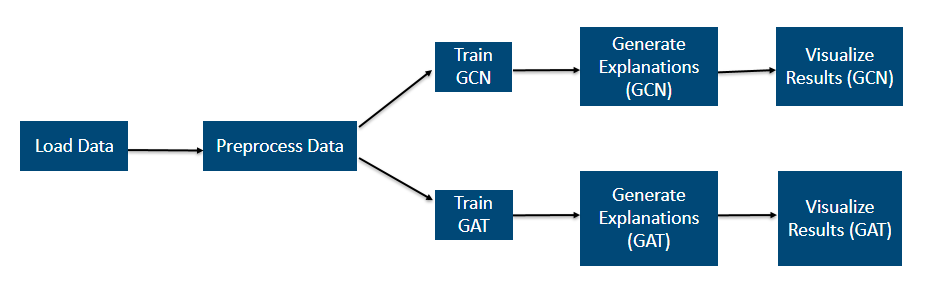

## Ring Property Enhancement

### Dataset
- **QM9 Dataset**: A collection of molecules represented as graphs and SMILES strings.
- Target property tensor (`y`) is enhanced with a **ring classification**:
  - **0**: Homocyclic ring (single atom type).
  - **1**: Heterocyclic ring (multiple atom types).

### Functions
#### `classify_ring_type(smiles)`
- **Purpose**: Classifies rings as homocyclic or heterocyclic.
- **Steps**:
  1. Converts SMILES to an RDKit molecule object.
  2. Logs invalid SMILES to `invalid_smiles.log`.
  3. Checks for rings:
     - **1**: Heterocyclic (multiple atom types in the ring).
     - **0**: Homocyclic (single atom type).
     - `None`: No rings or invalid SMILES.

#### `add_ring_property_to_y(dataset)`
- **Purpose**: Adds ring classification to the `y` tensor in the QM9 dataset.
- **Steps**:
  1. Iterates over molecules in the dataset.
  2. Uses `classify_ring_type` to compute the ring property.
  3. Appends the property to `y` for valid molecules.
  4. Returns the updated dataset.

### Processing
- **Invalid SMILES**: Logged and skipped.
- **Ring Classification**:
  - Molecules with **homocyclic rings**: `0`.
  - Molecules with **heterocyclic rings**: `1`.

### Outputs
- **Console**:
  - Displays counts of molecules with homocyclic and heterocyclic rings:
    ```
    Number of molecules with homocyclic rings: <count>
    Number of molecules with heterocyclic rings: <count>
    ```
- **Log File**: Invalid SMILES strings are recorded in `invalid_smiles.log`.

### Purpose
- Adds a structural feature (ring classification) to molecular datasets.
- Enhances machine learning models by incorporating key chemical topology insights.


In [6]:
# Load the QM9 dataset
dataset = QM9(root="data/QM9")

In [7]:
dataset[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

### **Interpreting the Example from dataset (QM9)**
The data object describes a **methane molecule (`CH₄`)** represented as a graph:
- **Nodes:** Represent the 5 atoms (1 carbon, 4 hydrogens).
- **Edges:** Represent the 8 bonds (bidirectional edges for the 4 C-H bonds).
- **Node Features (`x`):** Capture properties of the atoms.
- **Edge Features (`edge_attr`):** Describe the properties of the C-H bonds.
- **Target Properties (`y`):** Quantum chemistry-related values, likely for regression tasks.
- **3D Coordinates (`pos`):** Capture the spatial arrangement of atoms.
- **Atomic Numbers (`z`):** Specify the type of each atom.


In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [9]:
# Configure logging
logging.basicConfig(filename='invalid_smiles.log', level=logging.WARNING)

# Function to classify rings as homocyclic or heterocyclic
def classify_ring_type(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        logging.warning(f"Invalid SMILES encountered: {smiles}")
        return None  # Invalid SMILES
    
    ring_info = mol.GetRingInfo()
    if ring_info.NumRings() == 0:
        return None  # No rings
    
    for ring in ring_info.AtomRings():
        atom_types = {mol.GetAtomWithIdx(idx).GetAtomicNum() for idx in ring}
        if len(atom_types) > 1:  # Heteroatomic ring
            return 1
    return 0  # Homoatomic ring if all atoms in all rings are of the same type

# Function to add the ring classification property to the dataset
def add_ring_property_to_y(dataset):
    new_data_list = []
    for data in dataset:
        smiles = data.smiles
        ring_class = classify_ring_type(smiles)
        if ring_class is None:  # Skip molecules without rings or invalid SMILES
            continue
        
        y = data.y
        
        # Add ring classification to y
        ring_property_tensor = torch.tensor(
            [[ring_class]], dtype=torch.float
        ).expand(y.size(0), -1)
        y = torch.cat([y, ring_property_tensor], dim=1)
        
        # Create a new Data object with updated y
        new_data = Data(
            x=data.x,
            edge_index=data.edge_index,
            edge_attr=data.edge_attr,
            y=y,
            smiles=smiles
        )
        new_data_list.append(new_data)
    
    return new_data_list



import sys
import os
from rdkit import Chem
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Redirect stderr to null temporarily
sys.stderr = open(os.devnull, 'w')

dataset_with_ring = add_ring_property_to_y(dataset)

# Restore stderr
sys.stderr = sys.__stderr__


# Calculate metrics for homocyclic and heterocyclic molecules
num_homocyclic = sum(1 for data in dataset_with_ring if data.y[:, -1].item() == 0)
num_heterocyclic = sum(1 for data in dataset_with_ring if data.y[:, -1].item() == 1)

# Print metrics
print(f"Number of molecules with homocyclic rings: {num_homocyclic}")
print(f"Number of molecules with heterocyclic rings: {num_heterocyclic}")


Number of molecules with homocyclic rings: 25299
Number of molecules with heterocyclic rings: 90739


## Explanation of the Downsampling Function

### Purpose
- **Balances the dataset** by downsampling the majority class (molecules with rings) to match the size of the minority class (molecules without rings).  

### Process
- Separates molecules with and without rings.
- Randomly downsamples the majority class to the size of the minority class.
- Combines both classes and shuffles the dataset for balance.


In [10]:
# Function to downsample the majority class
def downsample_dataset(dataset, minority_class=0):
    # Separate the dataset into minority and majority classes
    minority_data = [data for data in dataset if data.y[:, -1].item() == minority_class]
    majority_data = [data for data in dataset if data.y[:, -1].item() != minority_class]
    
    # Downsample the majority class to match the minority class size
    downsampled_majority_data = random.sample(majority_data, len(minority_data))
    
    # Combine the downsampled majority class with the minority class
    balanced_dataset = minority_data + downsampled_majority_data
    random.shuffle(balanced_dataset)  # Shuffle the dataset to mix classes
    return balanced_dataset

# Downsample the dataset
balanced_dataset = downsample_dataset(dataset_with_ring, minority_class=0)

# Calculate new metrics
num_homocyclic_balanced = sum(1 for data in balanced_dataset if data.y[:, -1].item() == 0)
num_heterocyclic_balanced = sum(1 for data in balanced_dataset if data.y[:, -1].item() == 1)

# Print new metrics
print(f"Number of molecules with homocyclic rings (balanced): {num_homocyclic_balanced}")
print(f"Number of molecules with heterocyclic rings (balanced): {num_heterocyclic_balanced}")



Number of molecules with homocyclic rings (balanced): 25299
Number of molecules with heterocyclic rings (balanced): 25299


In [11]:
# Save the balanced dataset as a PyTorch tensor file
torch.save(balanced_dataset, 'balanced_dataset.pt')

print("Balanced dataset saved to balanced_dataset.pt")


Balanced dataset saved to balanced_dataset.pt


In [12]:
# Load the balanced dataset from the PyTorch file
balanced_dataset = torch.load('balanced_dataset.pt')

print("Balanced dataset loaded")


Balanced dataset loaded


## Dataset Splitting and DataLoader Setup

### Purpose
- **Splits the balanced dataset** into training (80%), validation (10%), and test (10%) sets using stratified sampling to maintain class balance.  
- **Prepares DataLoaders** for efficient batching during model training and evaluation.


In [13]:
all_labels = torch.tensor([data.y[0, -1].item() for data in balanced_dataset]) 
print(f"First few labels in the entire dataset: {all_labels[:10]}") 

train_indices, test_indices = train_test_split(
    range(len(balanced_dataset)),  
    test_size=0.2,  
    stratify=all_labels.cpu().numpy(), 
)

val_indices, test_indices = train_test_split(
    test_indices,  
    test_size=0.5,  
    stratify=all_labels[test_indices].cpu().numpy(),  
)

train_dataset = [balanced_dataset[i] for i in train_indices]
val_dataset = [balanced_dataset[i] for i in val_indices]
test_dataset = [balanced_dataset[i] for i in test_indices]

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Check if the split is correct and the DataLoader works
print(f"Train Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")
print(f"Test Loader: {len(test_loader)} batches")

# Extract labels for train, val, and test datasets
train_labels = torch.tensor([data.y[0, -1].item() for data in train_dataset]).long()  
val_labels = torch.tensor([data.y[0, -1].item() for data in val_dataset]).long()  
test_labels = torch.tensor([data.y[0, -1].item() for data in test_dataset]).long()  

# Print the first 10 labels of the train, validation, and test sets
print(f"First 10 labels in the training set: {train_labels[:10]}")
print(f"First 10 labels in the validation set: {val_labels[:10]}")
print(f"First 10 labels in the test set: {test_labels[:10]}")


First few labels in the entire dataset: tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 1.])
Train Loader: 1265 batches
Validation Loader: 159 batches
Test Loader: 5060 batches
First 10 labels in the training set: tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1])
First 10 labels in the validation set: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1])
First 10 labels in the test set: tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 0])


In [14]:
# Saving training data
torch.save(train_loader, 'rings_train_loader.pt')

print(" saved to 'rings_train_loader.pt'")

# Saving validation data
torch.save(val_loader, 'rings_val_loader.pt')

print("saved to 'rings_val_loader.pt'")

# Saving test data
torch.save(test_loader, 'rings_test_loader.pt')

print(" saved to 'rings_test_loader.pt'")

 saved to 'rings_train_loader.pt'
saved to 'rings_val_loader.pt'
 saved to 'rings_test_loader.pt'


In [15]:
# Load the saved data
train_loader = torch.load('rings_train_loader.pt')
print("Loaded train_loader from 'rings_train_loader.pt'")

val_loader = torch.load('rings_val_loader.pt')
print("Loaded val_loader from 'rings_val_loader.pt'")

test_loader = torch.load('rings_test_loader.pt')
print("Loaded test_loader from 'rings_test_loader.pt'")


Loaded train_loader from 'rings_train_loader.pt'
Loaded val_loader from 'rings_val_loader.pt'
Loaded test_loader from 'rings_test_loader.pt'


In [16]:
test_loader

#### Saving the data as ground truth for analysis

In [17]:
ring_graphs = []
for data in test_loader:
    if data.y[0, -1].item() == 1:
        ring_graphs.append(data)
        path = f'ring_example_graph_{len(ring_graphs)}.pt'
        torch.save(data, path)
      

In [18]:
ring_graphs = []
for data in test_loader:
    if data.y[0, -1].item() == 0:
        ring_graphs.append(data)
        path = f'homologous_example_graph_{len(ring_graphs)}.pt'
        torch.save(data, path)
      

In [19]:
# Labels for predicting
train_labels = torch.tensor([data.y[0,-1].item() for data in train_dataset])
val_labels = torch.tensor([data.y[0,-1].item() for data in val_dataset])
test_labels = torch.tensor([data.y[0,-1].item() for data in test_dataset])
test_labels

tensor([0., 0., 1.,  ..., 1., 1., 1.])

## Graph Convultion Network (GCN) Pipeline

### Training:

#### Model Architecture
- **Graph Convolutional Network (GCN)**:
  - Input layer, multiple hidden layers, and an output layer, implemented using **`GCNConv`**.
  - **ReLU activation** and **dropout** are applied between layers.
  - **Global mean pooling** aggregates node features into a graph-level representation.

#### Training Details
- **Loss Function**: Binary Cross-Entropy with Logits (`BCEWithLogitsLoss`), used for binary classification.
- **Optimizer**: Adam optimizer with a learning rate of 0.001.
- **Training Loop**:
  - Forward pass: Predicts outputs for the input graphs.
  - Backpropagation: Minimizes the loss function to update model weights.

#### Evaluation Metrics
- **Validation Loss**: Tracks model performance on the validation set.
- **Validation Accuracy**: Measures the proportion of correct predictions.

#### Process
1. **Train the model** for 20 epochs while tracking training loss, validation loss, and accuracy.
2. **Save the trained model** to a file (`best_gcn_model.pth`).
3. **Visualize performance**:
   - Plot training and validation losses.
   - Plot validation accuracy across epochs.

#### Purpose
- To train a GCN that learns molecular graph features and accurately predicts binary properties (e.g., homocyclic or heterocyclic ring structure).

After training saving model to save time to train again.

### Test:
- **Load model**: Loading the saved model.
- **Predictions on test data**: Checking accuracy while making predictions on unseen data.


![Screenshot](Screenshot_2025-01-26_114632-removebg-preview.png)


#### Figure 1: A simple GCN model

Epoch 1/20, Train Loss: 0.3823, Validation Loss: 0.2364, Validation Accuracy: 0.9117
Epoch 2/20, Train Loss: 0.2091, Validation Loss: 0.1401, Validation Accuracy: 0.9466
Epoch 3/20, Train Loss: 0.1574, Validation Loss: 0.1095, Validation Accuracy: 0.9628
Epoch 4/20, Train Loss: 0.1328, Validation Loss: 0.0990, Validation Accuracy: 0.9668
Epoch 5/20, Train Loss: 0.1189, Validation Loss: 0.1044, Validation Accuracy: 0.9668
Epoch 6/20, Train Loss: 0.1106, Validation Loss: 0.0866, Validation Accuracy: 0.9694
Epoch 7/20, Train Loss: 0.1044, Validation Loss: 0.0806, Validation Accuracy: 0.9731
Epoch 8/20, Train Loss: 0.0956, Validation Loss: 0.0706, Validation Accuracy: 0.9755
Epoch 9/20, Train Loss: 0.0902, Validation Loss: 0.0703, Validation Accuracy: 0.9759
Epoch 10/20, Train Loss: 0.0833, Validation Loss: 0.0631, Validation Accuracy: 0.9812
Epoch 11/20, Train Loss: 0.0757, Validation Loss: 0.0527, Validation Accuracy: 0.9806
Epoch 12/20, Train Loss: 0.0712, Validation Loss: 0.0617, Valid

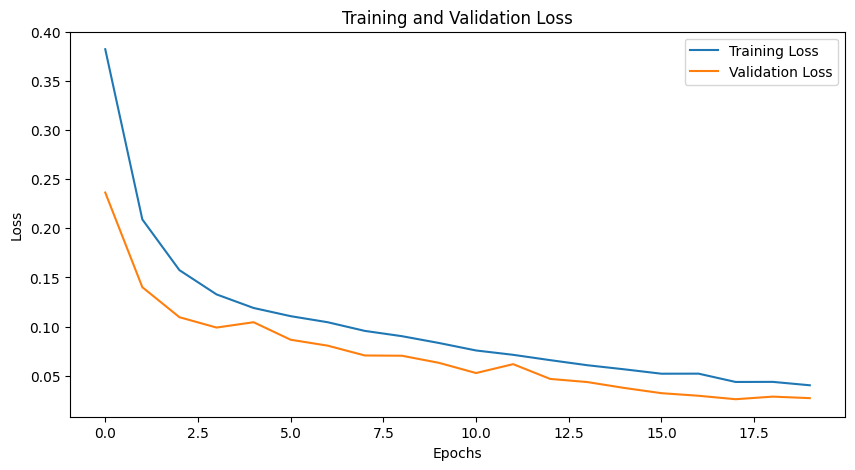

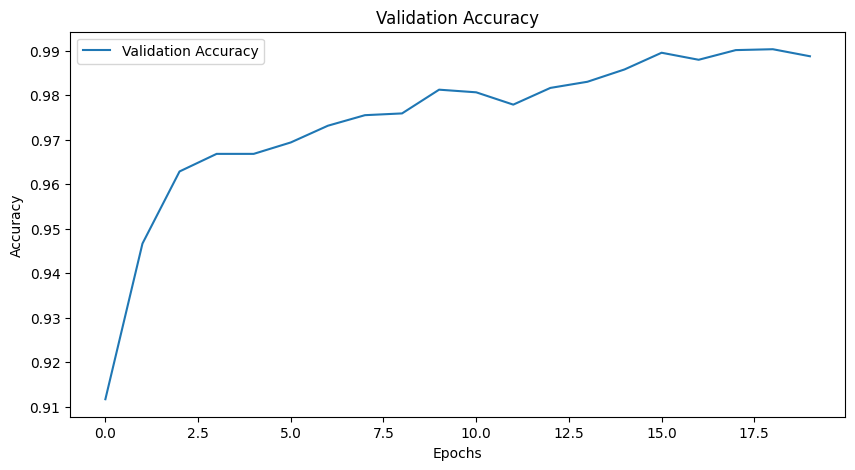

In [20]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)  # Graph-level pooling
        return x

        
device = 'cpu'

num_node_features = balanced_dataset[0].x.size(1)  
hidden_dim = 256
num_layers = 4
model = GCN(
    input_dim=num_node_features,
    hidden_dim=hidden_dim,
    output_dim=1,  
    num_layers=num_layers,
    dropout=0.3
).to(device)


criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        
        output = model(data.x, data.edge_index, data.batch)
        
        
        target = data.y[:, -1].squeeze()  
        output = output.squeeze()  
        
        loss = criterion(output, target)  
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch)
            
           
            target = data.y[:, -1].squeeze()  
            output = output.squeeze()  
            
            loss = criterion(output, target)
            total_loss += loss.item()

       
            pred = torch.round(torch.sigmoid(output))  
            correct += (pred == target).sum().item()
            total += target.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), 'best_gcn_model.pth')
print("Model saved to best_gcn_model.pth")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('gcn_Training and Validation Loss.png')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('gcn_Validation_accuracy.png')
plt.show()



#### Figure 2: Training the GCN model

In [21]:
# Loading the trained model for evaluation

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)  # Graph-level pooling
        return x


num_node_features = balanced_dataset[0].x.size(1)
device='cpu'
# Reinitialize the model
hidden_dim = 256
num_layers = 4
model = GCN(
    input_dim=num_node_features,
    hidden_dim=hidden_dim,
    output_dim=1,  # Binary classification
    num_layers=num_layers,
    dropout=0.3
)

# Load the model weights
model.load_state_dict(torch.load("best_gcn_model.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode



GCN(
  (convs): ModuleList(
    (0): GCNConv(11, 256)
    (1-2): 2 x GCNConv(256, 256)
    (3): GCNConv(256, 1)
  )
)

Accuracy: 0.9905


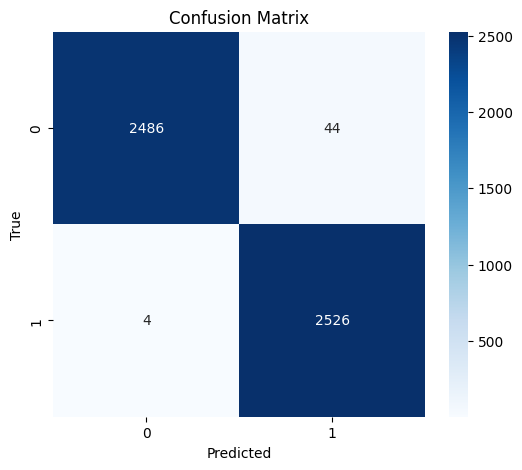

In [22]:
true_values = []
predicted_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        predicted_values.append(torch.sigmoid(output).item())  
        true_values.append(data.y[:, -1].item())

true_values = np.array(true_values)
predicted_values = np.array(predicted_values)
predicted_binary = (predicted_values > 0.5).astype(int)
accuracy = accuracy_score(true_values, predicted_binary)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_values, predicted_binary)

# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('gcn_cm.png')
plt.show()




#### Figure 3: Confusion matrix on the test data

## Understanding Information Theory and GNN Explainer

### Mathematical Foundations of Mutual Information

**Mutual Information (MI)** is a measure of the amount of information that one random variable contains about another.

- **Between two random variables:**
  $$
  I(X; Y) = \sum_{x \in X} \sum_{y \in Y} P(x, y) \log \frac{P(x, y)}{P(x)P(y)}
  $$

  - $P(x, y)$: Joint probability  
  - $P(x)$, $P(y)$: Marginal probabilities

- **In terms of entropy:**
  $$
  I(X; Y) = H(X) + H(Y) - H(X, Y)
  $$

  - $H(X)$, $H(Y)$: Individual entropies  
  - $H(X, Y)$: Joint entropy

---

### Insights into Joint and Conditional Entropies

- **Joint Entropy** can be expressed as:
  $$
  H(X, Y) = H(X) + H(Y \mid X) = H(Y) + H(X \mid Y)
  $$

  - $H(X \mid Y)$, $H(Y \mid X)$: Conditional entropies

- **Conditional Entropy** measures the uncertainty in $Y$ given $X$:
  $$
  H(Y \mid X) = -\sum_{x \in X, y \in Y} p(x, y) \log \frac{p(x, y)}{p(x)}
  $$


---

### Identifying Important Subgraphs and Features

- **Objective Function:**
  $$
  \max_{G_s} MI(Y; (G_s, X_s)) = H(Y) - H(Y \mid G = G_s, X = X_s)
  $$

  - Maximizes mutual information between the prediction ($\hat{y}$) and the explanation ($G_s$, $X_s$).

- **Mutual Information (MI):**
  - Measures how the identified subgraph ($G_s$) and features ($X_s$) influence the prediction ($\hat{y}$).

- **Conditional entropy** of $Y$ given $G_s$ and $X_s$:
  $$
  H(Y \mid G = G_s, X = X_s)
  $$

---

### Conditional Entropy and Compact Explanations

The mutual information objective simplifies to minimizing the conditional entropy as $H(Y)$ is constant for model $\phi$:

$$
H(Y \mid G = G_s, X = X_s) = -\mathbb{E}_{Y \mid G_s, X_s}[\log P_{\phi}(Y \mid G = G_s, X = X_s)]
$$

- $P_{\phi}$: Predicted probability of $Y$ according to the GNN model $\phi$ when only using $G_s$ and $X_s$.
- $\log P_{\phi}$: Taking the logarithm penalizes lower probabilities, emphasizing situations where the model is less confident in its predictions.
- $\mathbb{E}_{Y \mid G_s, X_s}$: Expectation (average) over the conditional distribution of $Y$, given $G_s$ and $X_s$.

---

### Compact Explanations

- A constraint is imposed on the subgraph to ensure the explanation is concise:
  $$
  |G_s| \leq K_M
  $$

  - $K_M$: Maximum number of nodes or edges.

- Denoising computational graph by using nodes that give maximum mutual information.


### Optimization Framework for GNNExplainer

#### Optimization Challenges
- Direct optimization is computationally intractable due to the exponential number of subgraphs \( G_s \).

##### Adjacency Matrix of Graph (\( A_c \)):

**Graph Representation:**
- The figure below represents an undirected graph with 4 nodes.

**Adjacency Matrix:**
- The adjacency matrix \( A_c \) corresponding to the graph is provided in Table 1.



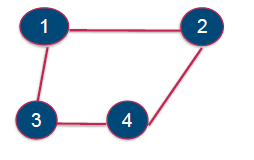

**Figure 4:** Undirected graph (4 nodes) 

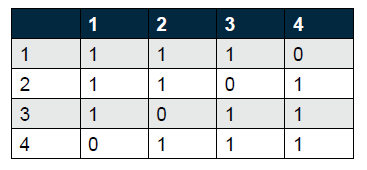

**Table 1:** Adjacency Matrix of the graph


##### Fractional Adjacency Matrix (\( A_s \))
- Represents a **soft selection of edges** for the subgraph.

**Example Layout:**
- The fractional adjacency matrix \( A_s \) is provided in Table 2.

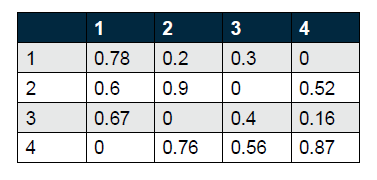

**Table 2:** Fractional Adjacency Matrix (\( A_s \))

### Optimization Challenges
- Direct optimization is computationally intractable due to the exponential number of subgraphs \( G_s \).

---

### Relaxation via Fractional Adjacency Matrix

-  A fractional adjacency matrix ($A_s \in [0, 1]^{n \times n}$) represents the subgraph.
- **Subgraph Constraints**:
  $$
  A_s[j, k] \leq A_c[j, k]
  $$


##### Objective Function with relaxation:

- Minimize the expected entropy over the subgraph distribution:  
  $$
  \mathbb{E}_{G_S \sim \mathcal{G}} \big[ H(Y \mid G = G_S, X = X_S) \big]
  $$

- For concave functions (e.g., entropy), **Jensen's Inequality** applies:  
  $$
  \mathbb{E}_{G_S \sim \mathcal{G}} \big[ H(Y \mid G = G_S, X = X_S) \big] \geq H(Y \mid G = \mathbb{E}[G_S], X = X_S)
  $$

- The surrogate avoids sampling the subgraph distribution, making computation more efficient:  
  $$
  \min_G H(Y \mid G = \mathbb{E}[G_S], X = X_S)
  $$


##### Optimization Challenge:
- Neural networks are non-convex, making direct optimization infeasible.

##### Solution:
- Use **mean-field variational approximation** to decompose $G$ into a multivariate Bernoulli distribution:  
  $$
  P_G(G_S) = \prod_{(j, k) \in \mathcal{G}} A_S[j, k]
  $$

- $A_S[j, k]$ represents soft probabilities for edges $(j, k)$.  
- The method models whether an edge is included or excluded probabilistically.


### Efficient Objective Function

$$
\min_{M} \sum_{c=1}^{C} \mathbf{1}[y = c] \log P_{\phi}(Y = y \mid G = A_S \odot \sigma(M), X = X_S)
$$

- $M \in \mathbb{R}^{n \times n}$: The **mask** to be learned, representing edge importance  
- $\odot$: Element-wise multiplication  
- $\sigma(M)$: Sigmoid function that maps $M$ values to probabilities between $[0, 1]$  
- $P_{\phi}$: The GNN's prediction probability for the true label $y$


### Joint Learning of Graph Structure and Node Features

#### Feature Selection:
- A binary mask $F$ is learned to identify and retain key features while excluding non-essential ones.  
- This process ensures the inclusion of only the most relevant features, providing additional explanatory power on top of the graph structure $G_S$.

#### Optimization:
- The method combines **graph structure** ($G_S$) and **node features** ($F$) to maximize mutual information between the predictions and the data:

$$
MI(Y; (G_S, F))
$$


## Mask Optimization in GNNExplainer

### Purpose of the Mask
- The **mask** is a set of learnable parameters applied to:
  - **Node features** (`node_mask`) to identify the most influential attributes.
  - **Edges** (`edge_mask`) to determine critical connections in the graph.

### Optimization Process
1. **Initialization**:
   - Masks for node features and edges are initialized randomly (e.g., small random values).
   - These masks are continuous variables, even though the final importance scores are interpreted as discrete.

2. **Forward Pass**:
   - The GNN model is run on the graph, applying the masks as multiplicative weights on:
     - Node features: `masked_features = mask * features`
     - Edges: `masked_adj = mask * adjacency_matrix`

3. **Loss Function**:
   - The explainer optimizes the masks to maximize the agreement between:
     - The model’s original prediction (`original_output`).
     - The prediction using the masked graph (`masked_output`).
   - The loss ensures the masked graph produces similar outputs, retaining only the essential components.

   **Loss Components**:
   - **Prediction Loss**: Ensures the masked graph preserves the original prediction.
   - **Sparsity Loss**: Encourages the mask to focus on a small subset of nodes and edges, making the explanation concise.
   - **Entropy Loss**: Smoothens the mask values to avoid binary jumps too early.

4. **Gradient-Based Optimization**:
   - Gradients of the loss are computed with respect to the mask parameters.
   - An optimizer (e.g., Adam) updates the masks iteratively, refining their values over multiple epochs.

5. **Final Output**:
   - The learned masks represent importance scores for nodes and edges.
   - Higher scores indicate greater relevance to the prediction.

### Result
- The optimized masks highlight the minimal subset of nodes, edges, and features most critical for the model's decision-making process, ensuring interpretability and focus.


#### GNN Explainer on heterocyclic ring

In [23]:
# Load the PyTorch Geometric Data object
path = "ring_example_graph_64.pt" 
example_data = torch.load(path)

# Move data to the same device as the model
device = next(model.parameters()).device  
example_data = example_data.to(device)  

smiles=example_data.smiles[0]

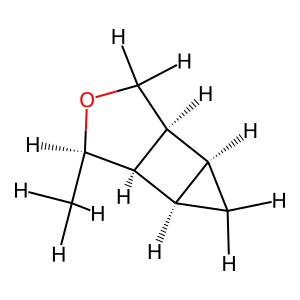

In [24]:
# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smiles)

# Add explicit hydrogens to the molecule
mol_with_h = Chem.AddHs(mol)

# Draw the molecule
Draw.MolToImage(mol_with_h, kekulize=True)


#### Figure 5: SMILES Representation of a Molecule with a Heteroatom (Oxygen) in the Ring

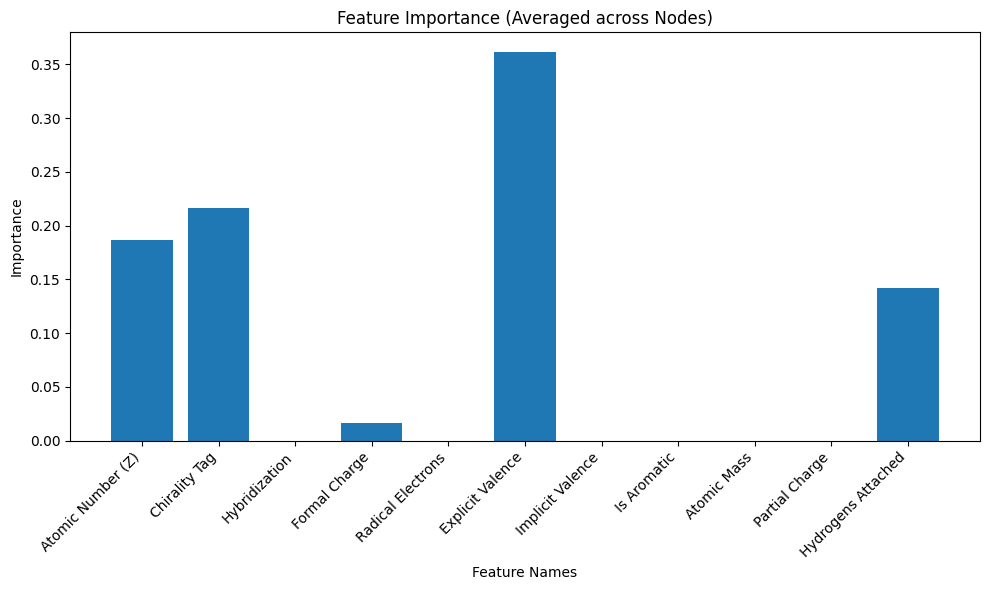

In [25]:
# Define the explainer with GNNExplainer directly
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),  # Directly pass GNNExplainer here
    explanation_type='model',  # Type of explanation (model-level)
    node_mask_type='attributes',  # Explaining node features
    edge_mask_type='object',  # Explaining edges
    model_config=dict(
        mode='binary_classification',  
        task_level='graph',  
        return_type='raw'  # Use 'raw' for binary classification outputs
    ),
)


# Generate explanations for the data
explanation = explainer(
    x=example_data.x,
    edge_index=example_data.edge_index,
    batch=example_data.batch
)

# Calculate the mean importance for each feature across all nodes (axis=0)
feature_importance = explanation.node_mask.mean(dim=0)
feature_names = [
    "Atomic Number (Z)",
    "Chirality Tag",
    "Hybridization",
    "Formal Charge",
    "Radical Electrons",
    "Explicit Valence",
    "Implicit Valence",
    "Is Aromatic",
    "Atomic Mass",
    "Partial Charge",
    "Hydrogens Attached",
]

# Visualize feature importance
plt.figure(figsize=(10, 6))  # Adjusted the figure size for better readability

# Create a bar plot with the feature importance
plt.bar(range(len(feature_importance)), feature_importance.cpu().numpy())

# Add title and labels
plt.title("Feature Importance (Averaged across Nodes)")
plt.xlabel("Feature Names")
plt.ylabel("Importance")

# Set the x-ticks to correspond to the feature names
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate for readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


### Figure 6: Feature Importance in GCN Prediction (Heterocyclic)
Explicit valence contributes most to the model's predictions.

#### Reason
Explicit valence likely contributes most to the predictions because it directly influences the chemical properties and reactivity of atoms, particularly in heterocyclic compounds where variations in valence impact the overall electronic structure and stability of the ring. This makes it a critical feature for a GCN to identify patterns relevant to prediction tasks.

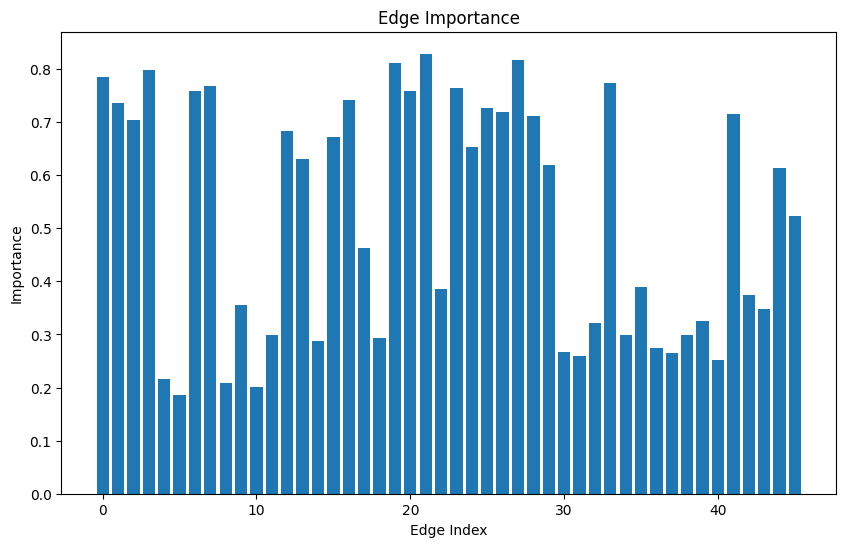

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(explanation.edge_mask)), explanation.edge_mask.cpu().numpy())
plt.title("Edge Importance")
plt.xlabel("Edge Index")
plt.ylabel("Importance")
plt.show()


#### Figure 7: Edge Importance in GCN Prediction (Heterocyclic)

Node Importance: tensor([[0.0000, 0.5369, 0.0000, 0.0000, 0.0000, 0.2534, 0.0000, 0.0000, 0.0000,
         0.0000, 0.6927],
        [0.0000, 0.5084, 0.0000, 0.0000, 0.0000, 0.3386, 0.0000, 0.0000, 0.0000,
         0.0000, 0.5088],
        [0.0000, 0.0000, 0.0000, 0.3430, 0.0000, 0.3310, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.6182, 0.0000, 0.0000, 0.0000, 0.2736, 0.0000, 0.0000, 0.0000,
         0.0000, 0.6249],
        [0.0000, 0.5978, 0.0000, 0.0000, 0.0000, 0.6056, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2572],
        [0.0000, 0.5368, 0.0000, 0.0000, 0.0000, 0.6409, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2955],
        [0.0000, 0.5801, 0.0000, 0.0000, 0.0000, 0.4509, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3288],
        [0.0000, 0.5021, 0.0000, 0.0000, 0.0000, 0.5496, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2863],
        [0.0000, 0.5837, 0.0000, 0.0000, 0.0000, 0.5860, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2906],
        [0.5389, 0.0

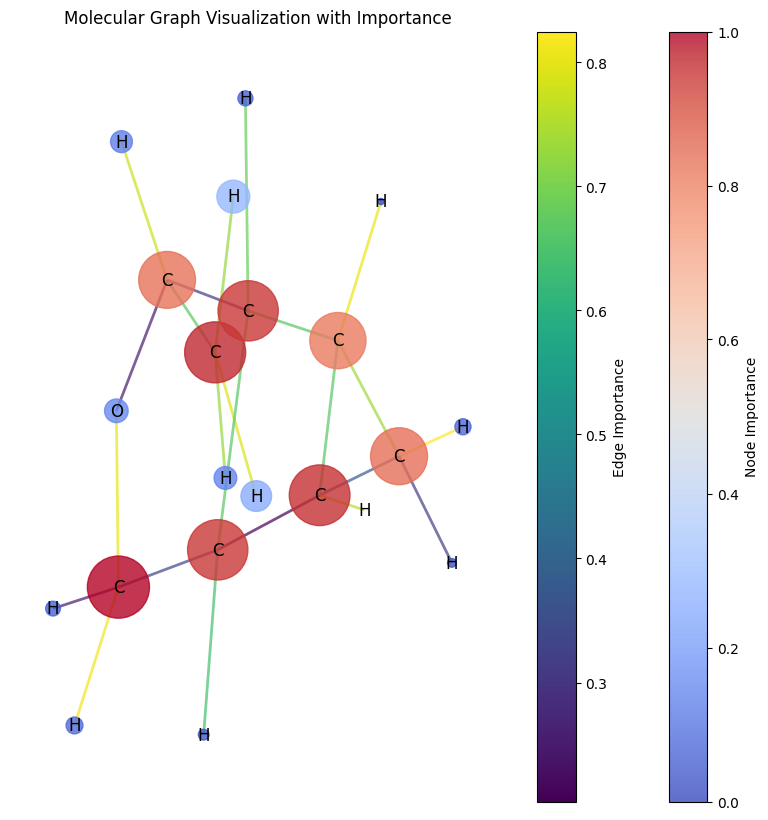

In [27]:
torch.manual_seed(42)
random.seed(42)

# Define the explainer with GNNExplainer directly
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),  # Directly pass GNNExplainer here
    explanation_type='model',  # Type of explanation (model-level)
    node_mask_type='attributes',  # Explaining node features
    edge_mask_type='object',  # Explaining edges
    model_config=dict(
        mode='binary_classification',  
        task_level='graph',  
        return_type='raw'  # Use 'raw' for binary classification outputs
    ),
)


# Generate explanations for the data
explanation = explainer(
    x=example_data.x,
    edge_index=example_data.edge_index,
    batch=example_data.batch
)

# Print and visualize the node and edge importances
print("Node Importance:", explanation.node_mask)  # Importance of nodes/features
print("Edge Importance:", explanation.edge_mask)  # Importance of edges

# Extract node and edge importance
node_importance = explanation.node_mask.mean(dim=1)  # Mean importance for each node
node_importance = (node_importance - node_importance.min()) / (node_importance.max() - node_importance.min())
edge_importance = explanation.edge_mask  # Mean across all edges


# Create a NetworkX graph
G = to_networkx(example_data, to_undirected=True)

# Node feature (example: using the atomic types for labels as previously defined)
node_to_element = {}
for node in range(example_data.num_nodes):
    if node in [0, 1, 3, 4, 5, 6, 7, 8]:
        node_to_element[node] = 'C'  # Carbon
    elif node == 2:
        node_to_element[node] = 'O'  # Oxygen
    else:
        node_to_element[node] = 'H'  # Hydrogen

# Normalize edge importance values to range [0, 1] for the colormap
norm = plt.Normalize(vmin=edge_importance.min().item(), vmax=edge_importance.max().item())
cmap = plt.cm.viridis  # Use a colormap like 'viridis'
edge_colors = cmap(norm(edge_importance.cpu().numpy()))

# Increase the scaling factor for larger nodes
node_size_factor = 2000  # Adjust this factor to make nodes bigger
node_sizes = [node_importance[i].item() * node_size_factor for i in range(len(node_importance))]

# Generate node positions using a layout (spring layout in this case)
pos = nx.spring_layout(G, seed=42)  # Generate positions for nodes

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,  # Larger node sizes
    node_color=node_importance.cpu().numpy(),  # Use node importance values for coloring
    cmap='coolwarm',
    alpha=0.8,
    ax=ax  # Pass the axis here
)

# Draw edges with properly mapped colors
edges = nx.draw_networkx_edges(
    G, pos,
    width=2,
    edge_color=edge_colors,  # Now in RGBA format
    alpha=0.7,
    ax=ax  # Pass the axis here
)

# Draw atom types (labels) instead of node numbers
nx.draw_networkx_labels(
    G, pos,
    labels=node_to_element,  # Use atom types as labels
    font_size=12,  # Adjust font size as needed
    ax=ax  # Pass the axis here
)

# Create colorbar for nodes
plt.colorbar(nodes, ax=ax, label='Node Importance')

# Create colorbar for edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array, as colorbar doesn't need data to be visualized
plt.colorbar(sm, ax=ax, label='Edge Importance')

# Add title and display
plt.title('Molecular Graph Visualization with Importance')
plt.axis('off')
plt.show()


#### Figure 8: Graph Visualization of Node and Edge Importance (Heterocyclic)
Highlights greater edge importance for bond connected to oxygen and higher node importance for carbons within the ring structure and linked to the heteroatom (oxygen).

#### GNN Explainer on homocyclic ring

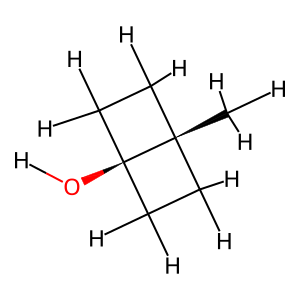

In [28]:
# Load the PyTorch Geometric Data object
path = "homologous_example_graph_61.pt" 
example_data = torch.load(path)

# Move data to the same device as the model
device = next(model.parameters()).device  
example_data = example_data.to(device)  

smiles=example_data.smiles[0]
# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smiles)

# Add explicit hydrogens to the molecule
mol_with_h = Chem.AddHs(mol)

# Draw the molecule
Draw.MolToImage(mol_with_h, kekulize=True)


#### Figure 9: SMILES Representation of Homocyclic Rings

Node Importance: tensor([[0.0000, 0.3198, 0.0000, 0.0000, 0.0000, 0.2614, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2703],
        [0.0000, 0.2708, 0.0000, 0.0000, 0.0000, 0.3397, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.3141, 0.0000, 0.0000, 0.0000, 0.3299, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2320],
        [0.0000, 0.2689, 0.0000, 0.0000, 0.0000, 0.2892, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2513],
        [0.0000, 0.3366, 0.0000, 0.0000, 0.0000, 0.3445, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5066, 0.0000, 0.3897, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3356],
        [0.0000, 0.2899, 0.0000, 0.0000, 0.0000, 0.2944, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2824],
        [0.0000, 0.2431, 0.0000, 0.0000, 0.0000, 0.2750, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2535],
        [0.2905, 0.0000, 0.0000, 0.0000, 0.0000, 0.2575, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.2777, 0.0

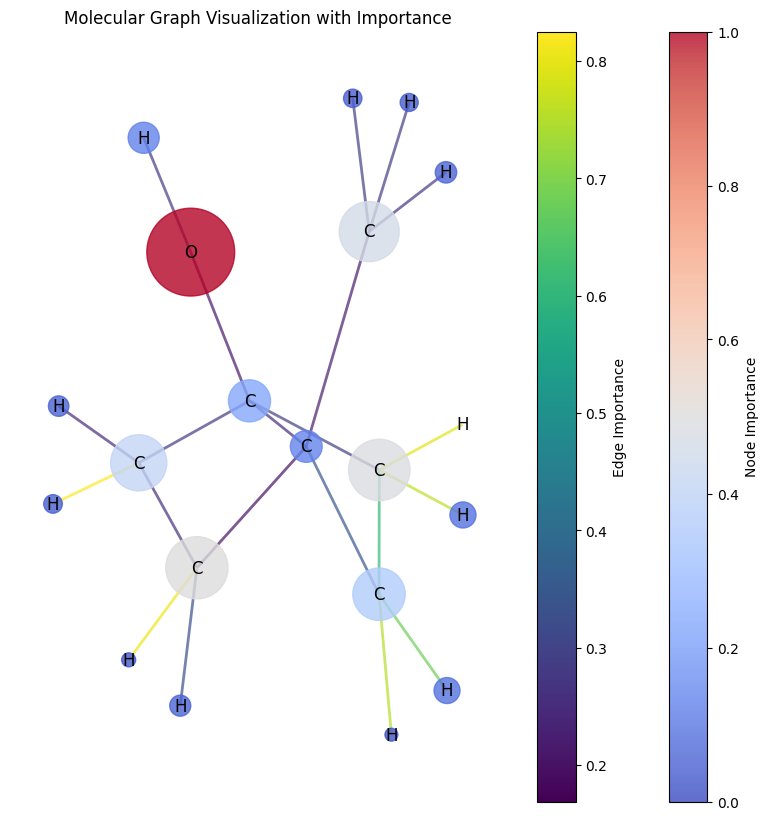

In [29]:
torch.manual_seed(42)
random.seed(42)
# Set the model to evaluation mode
model.eval()

# Define the explainer with GNNExplainer directly
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),  # Directly pass GNNExplainer here
    explanation_type='model',  # Type of explanation (model-level)
    node_mask_type='attributes',  # Explaining node features
    edge_mask_type='object',  # Explaining edges
    model_config=dict(
        mode='binary_classification',  
        task_level='graph',  
        return_type='raw'    # Use 'raw' for binary classification outputs
    ),
)


# Generate explanations for the data
explanation = explainer(
    x=example_data.x,
    edge_index=example_data.edge_index,
    batch=example_data.batch
)

# Print and visualize the node and edge importances
print("Node Importance:", explanation.node_mask)  # Importance of nodes/features
print("Edge Importance:", explanation.edge_mask)  # Importance of edges
# Extract node and edge importance
node_importance = explanation.node_mask.mean(dim=1)  # Mean importance for each node
node_importance = (node_importance - node_importance.min()) / (node_importance.max() - node_importance.min())
edge_importance = explanation.edge_mask  # Mean across all edges


# Create a NetworkX graph
G = to_networkx(example_data, to_undirected=True)

# Node feature (example: using the atomic types for labels as previously defined)
node_to_element = {}
for node in range(example_data.num_nodes):
    if node in [0, 1, 2, 3, 4, 6, 7]:
        node_to_element[node] = 'C'  # Carbon
    elif node == 5:
        node_to_element[node] = 'O'  # Oxygen
    else:
        node_to_element[node] = 'H'  # Hydrogen

# Normalize edge importance values to range [0, 1] for the colormap
norm = plt.Normalize(vmin=edge_importance.min().item(), vmax=edge_importance.max().item())
cmap = plt.cm.viridis  # Use a colormap like 'viridis'
edge_colors = cmap(norm(edge_importance.cpu().numpy()))

# Increase the scaling factor for larger nodes
node_size_factor = 4000  # Adjust this factor to make nodes bigger
node_sizes = [node_importance[i].item() * node_size_factor for i in range(len(node_importance))]

# Generate node positions using a layout (spring layout in this case)
pos = nx.spring_layout(G, seed=42)  # Generate positions for nodes

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,  # Larger node sizes
    node_color=node_importance.cpu().numpy(),  # Use node importance values for coloring
    cmap='coolwarm',
    alpha=0.8,
    ax=ax  # Pass the axis here
)

# Draw edges with properly mapped colors
edges = nx.draw_networkx_edges(
    G, pos,
    width=2,
    edge_color=edge_colors,  # Now in RGBA format
    alpha=0.7,
    ax=ax  # Pass the axis here
)

# Draw atom types (labels) instead of node numbers
nx.draw_networkx_labels(
    G, pos,
    labels=node_to_element,  # Use atom types as labels
    font_size=12,  # Adjust font size as needed
    ax=ax  # Pass the axis here
)

# Create colorbar for nodes
plt.colorbar(nodes, ax=ax, label='Node Importance')

# Create colorbar for edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array, as colorbar doesn't need data to be visualized
plt.colorbar(sm, ax=ax, label='Edge Importance')

# Add title and display
plt.title('Molecular Graph Visualization with Importance')
plt.axis('off')
plt.show()

#### Figure 10: Explainer Analysis for Homocyclic Ring
The explainer assigns lower importance to edges within the ring, while giving higher node feature importance to heteroatoms outside the ring as compared to the others.

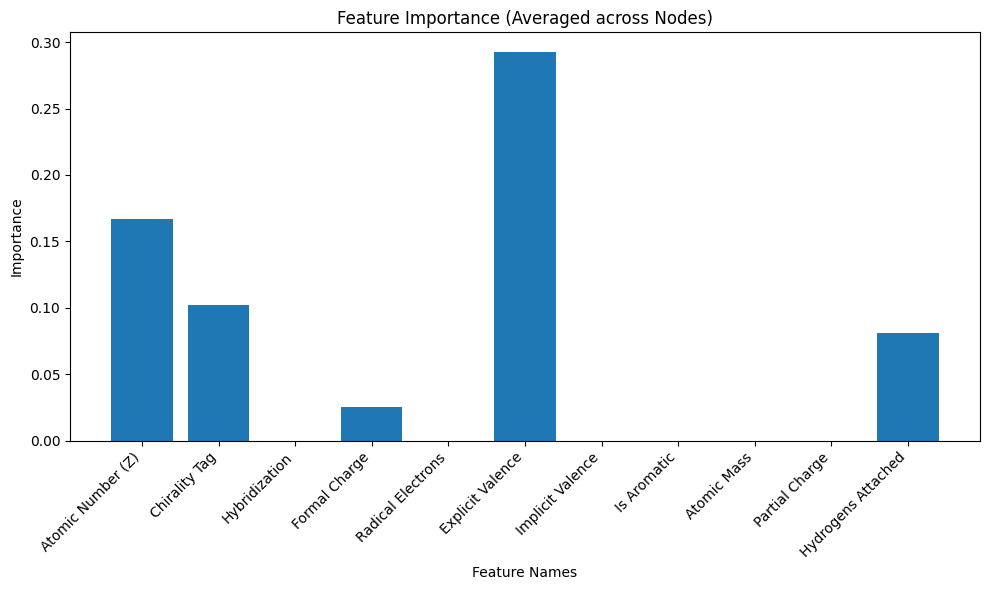

In [30]:
# Calculate the mean importance for each feature across all nodes (axis=0)
feature_importance = explanation.node_mask.mean(dim=0)
feature_names = [
    "Atomic Number (Z)",
    "Chirality Tag",
    "Hybridization",
    "Formal Charge",
    "Radical Electrons",
    "Explicit Valence",
    "Implicit Valence",
    "Is Aromatic",
    "Atomic Mass",
    "Partial Charge",
    "Hydrogens Attached",
]

# Visualize feature importance
plt.figure(figsize=(10, 6))  # Adjusted the figure size for better readability

# Create a bar plot with the feature importance
plt.bar(range(len(feature_importance)), feature_importance.cpu().numpy())

# Add title and labels
plt.title("Feature Importance (Averaged across Nodes)")
plt.xlabel("Feature Names")
plt.ylabel("Importance")

# Set the x-ticks to correspond to the feature names
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate for readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


#### Figure 11: Feature Contribution to Prediction (Homocyclic)
Similar to the heterocyclic case, explicit valence and atomic features significantly contribute to the model's prediction in the homocyclic structure.

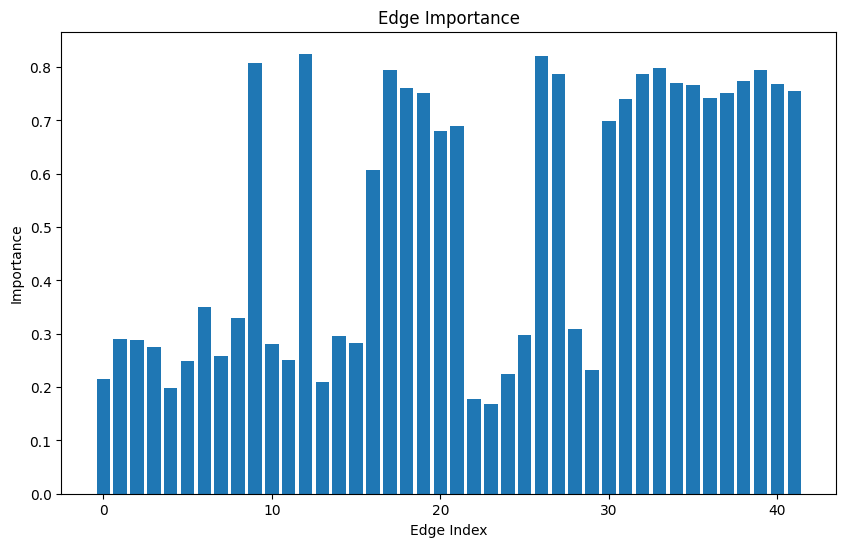

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(explanation.edge_mask)), explanation.edge_mask.cpu().numpy())
plt.title("Edge Importance")
plt.xlabel("Edge Index")
plt.ylabel("Importance")
plt.show()


#### Figure 12: Edge importance for prediction of GCN (Homoocyclic)

## Graph Attention Network (GAT) Model

### Model Architecture: GAT (Graph Attention Network)
- The **GAT model** is designed for graph-based data, leveraging **attention mechanisms** to assign different weights to different nodes in the graph during aggregation.
- It is built using the **GATConv** layers, which perform attention-based graph convolutions. The key components are:
  - **Multi-head Attention**: The model uses multiple attention heads (`heads`) for each convolution to learn different representations of node relationships.
  - **Global Mean Pooling**: After node feature transformations, the model uses **global mean pooling** to aggregate node features into a graph-level representation.
  - **Dropout**: Dropout is applied during training to prevent overfitting.

#### Key Components:
1. **Layers**: The model consists of multiple layers of `GATConv`, where each layer applies attention to the graph and updates node features:
   - The first layer takes **input_dim** features and applies attention to produce **hidden_dim** features with `heads` attention heads.
   - Intermediate layers use hidden dimensions, multiplying by the number of attention heads (`hidden_dim * heads`).
   - The final layer outputs **output_dim** features with a single attention head, ensuring a graph-level prediction.

2. **Activation**: The model applies **ReLU activation** after each GATConv layer to introduce non-linearity.
3. **Output**: The final output is passed through a **sigmoid function** to produce binary classification predictions in the range [0, 1].

### Model Training

#### Optimizer and Loss Function:
- **Binary Cross Entropy Loss (BCELoss)**: Suitable for binary classification tasks, this loss function is used to compare the predicted probabilities and the true binary labels.
- **Adam Optimizer**: An adaptive optimizer is used with a learning rate of 0.0005 and weight decay for regularization.
- **Cyclic Learning Rate Scheduler**: The learning rate oscillates between a minimum (`base_lr=0.0001`) and maximum (`max_lr=0.001`) value to help the model escape local minima and stabilize training.

#### Training and Validation Loops:
1. **Training Loop**:
   - The model is trained for 20 epochs, updating weights based on the gradient of the loss.
   - In each batch, the model computes the output for the current graph, calculates the loss with respect to the ground truth labels, and updates the weights via backpropagation.
   - The training loss is accumulated and averaged over all batches.
   
2. **Validation Loop**:
   - After each training epoch, the model is evaluated on the validation set without gradient updates.
   - Validation loss is calculated similarly to the training loss but used to monitor the model’s performance on unseen data.

### Output:
- For each epoch, the training and validation loss are printed.
- **Learning rate scheduling**: The `scheduler.step(val_loss)` adjusts the learning rate based on validation loss to help with optimization.

### Purpose:
- The **GAT model** learns node and graph-level representations from graph-structured data using attention mechanisms, enabling it to classify graphs based on their features and structure.
### Saving the model
### Loading and test the model

In [32]:

# Define the GAT Model
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, heads):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads, concat=True))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True))
        self.convs.append(GATConv(hidden_dim * heads, output_dim, heads=1, concat=False))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)  # Global mean pooling for graph-level output
        return torch.sigmoid(x)  # Binary classification output in [0, 1]

# Initialize Model
device = 'cpu'

input_dim = balanced_dataset[0].x.shape[1]  # Get the feature dimension from the first graph
gat_model = GAT(
    input_dim=input_dim,
    hidden_dim=128,
    output_dim=1,  
    num_layers=5,
    dropout=0.3,
    heads=4
).to(device)

# Define Optimizer, Loss, and Scheduler
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=10)


In [33]:

train_losses = []
val_losses = []

for epoch in range(20):
    # Training Loop
    gat_model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)

        # Directly use the last column for target
        target = data.y[:, -1]  # Assuming data.y is a 2D tensor with multiple columns

        optimizer.zero_grad()
        output = gat_model(data.x, data.edge_index, data.batch).squeeze(1)
        loss = criterion(output, target.float())  # Ensure target is float for BCE loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store train loss

    # Validation Loop
    gat_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            # Directly use the last column for target
            target = data.y[:, -1]  

            output = gat_model(data.x, data.edge_index, data.batch).squeeze(1)
            loss = criterion(output, target.float())
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Store validation loss

    print(f"Epoch {epoch+1}/20, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

Epoch 1/20, Train Loss: 0.3735, Val Loss: 0.2772
Epoch 2/20, Train Loss: 0.2703, Val Loss: 0.2565
Epoch 3/20, Train Loss: 0.2138, Val Loss: 0.1928
Epoch 4/20, Train Loss: 0.1621, Val Loss: 0.1269
Epoch 5/20, Train Loss: 0.1326, Val Loss: 0.1426
Epoch 6/20, Train Loss: 0.1135, Val Loss: 0.0885
Epoch 7/20, Train Loss: 0.1002, Val Loss: 0.0770
Epoch 8/20, Train Loss: 0.0884, Val Loss: 0.0901
Epoch 9/20, Train Loss: 0.0778, Val Loss: 0.0576
Epoch 10/20, Train Loss: 0.0681, Val Loss: 0.0479
Epoch 11/20, Train Loss: 0.0625, Val Loss: 0.0434
Epoch 12/20, Train Loss: 0.0567, Val Loss: 0.0425
Epoch 13/20, Train Loss: 0.0530, Val Loss: 0.0393
Epoch 14/20, Train Loss: 0.0494, Val Loss: 0.0324
Epoch 15/20, Train Loss: 0.0450, Val Loss: 0.0354
Epoch 16/20, Train Loss: 0.0414, Val Loss: 0.0264
Epoch 17/20, Train Loss: 0.0400, Val Loss: 0.0232
Epoch 18/20, Train Loss: 0.0369, Val Loss: 0.0252
Epoch 19/20, Train Loss: 0.0352, Val Loss: 0.0250
Epoch 20/20, Train Loss: 0.0330, Val Loss: 0.0188


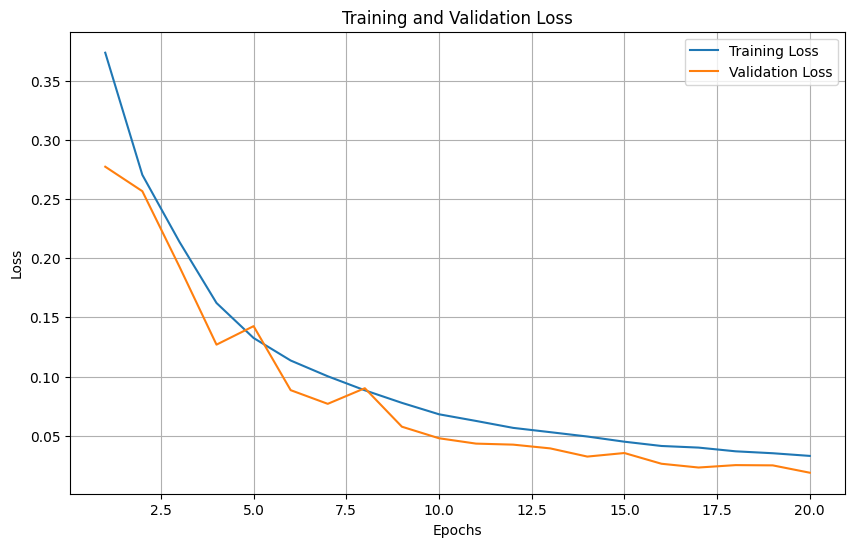

In [34]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses, label='Training Loss')
plt.plot(range(1, 21), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('gat_Training and Validation Loss.png')
plt.show()

#### Figure 13: Training of GAT model

In [35]:
torch.save(gat_model.state_dict(), "best_gat_model.pth")
print("Model state_dict saved as 'best_gat_model.pth'.")


Model state_dict saved as 'best_gat_model.pth'.


In [36]:
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, heads):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=heads, concat=True))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True))
        # Increase the number of layers if your saved model has more layers
        self.convs.append(GATConv(hidden_dim * heads, output_dim, heads=1, concat=False))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)  # Global mean pooling for graph-level output
        return torch.sigmoid(x)  # Binary classification output in [0, 1]


gat_model = GAT(
    input_dim=11,    
    hidden_dim=128,  
    output_dim=1,    
    num_layers=5,   
    dropout=0.3,     
    heads=4          
)

gat_model.load_state_dict(torch.load("best_gat_model.pth"))
gat_model.eval()
print("Model successfully loaded and set to evaluation mode.")


Model successfully loaded and set to evaluation mode.


Accuracy: 0.9923
Confusion Matrix:
[[2511   19]
 [  20 2510]]


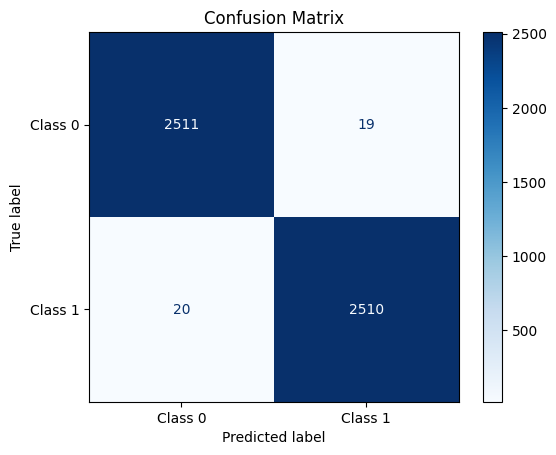

In [37]:

gat_model.eval()
true_values = []
predicted_values = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        target = data.y[:, -1]
        # Get predictions
        output = gat_model(data.x, data.edge_index, data.batch).squeeze(1)
        predicted = (output > 0.5).long()  

        # Store true and predicted values
        true_values.extend(target.cpu().numpy())
        predicted_values.extend(predicted.cpu().numpy())

# Convert to NumPy arrays for metric calculation
true_values = np.array(true_values)
predicted_values = np.array(predicted_values)

# Calculate Accuracy
accuracy = (true_values == predicted_values).mean()

# Print Accuracy
print(f"Accuracy: {accuracy:.4f}")

# Calculate and Print Confusion Matrix
cm = confusion_matrix(true_values, predicted_values)
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig('gat_cm.png')
plt.show()


#### Figure 14: Confusion matrix on test data

## How AttentionExplainer works

### Purpose
- The **AttentionExplainer** is used to identify which parts of a graph (specifically the edges) contribute most to the prediction made by a model. This is particularly useful for graph neural networks like **Graph Attention Networks (GATs)**, where attention mechanisms determine the influence of neighboring nodes and edges in the decision-making process.

### Key Steps and Components

#### Model Configuration
- **`model_config`**:
  - The configuration specifies how the explanation should be generated:
    - `mode='binary_classification'`: Indicates that the task is binary classification.
    - `task_level='graph'`: Specifies that the explanation will focus on graph-level predictions (e.g., classifying the entire graph).
    - `return_type='raw'`: Returns raw model outputs (logits before any activation like `sigmoid`), which allows the explanation to be based on the untransformed prediction scores.

#### Initializing the Explainer
- **Explainer Setup**:
  - The **`AttentionExplainer`** is used to explain the model's behavior.
  - **`edge_mask_type='object'`**: Indicates that the explanation will focus on the edges and their importance in the prediction.
  - **`explanation_type='model'`**: This specifies that the explanation is for the entire model's behavior, not individual predictions or nodes.

#### Graph Data Loading
- The graph data is loaded from a file and transferred to the appropriate device (CPU or GPU) where the model is located. This step ensures that the input data is compatible with the model during explanation generation.

#### Generate Explanations
- The **explainer** is applied to the graph data, where:
  - **`x`** represents the node features (information about the nodes in the graph).
  - **`edge_index`** defines the edges or connections between nodes in the graph.
  - **`batch`** provides batch information, which is important when multiple graphs are processed in a single batch.
  
  The explainer computes importance scores for both the nodes and edges, focusing on edge-level importance in this case.

#### Outputs
- **Edge Mask**: The **edge mask** represents the importance of the edges in the graph. Each edge is assigned a score indicating its contribution to the model's prediction. Higher values correspond to edges that have a greater influence on the prediction.

### Result
- The optimized edge mask helps to highlight the critical edges in the graph, making the model's decision-making process more transparent. This allows for better interpretability, especially when using attention mechanisms in graph-based models like GATs.


In [38]:
# Load the PyTorch Geometric Data object
path = 'ring_example_graph_64.pt' 
example_data = torch.load(path)
example_data = example_data.to(device)

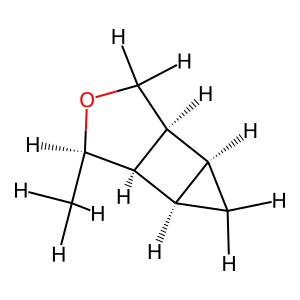

In [39]:
smiles=example_data.smiles[0]
# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smiles)

# Add explicit hydrogens to the molecule
mol_with_h = Chem.AddHs(mol)

# Draw the molecule
Draw.MolToImage(mol_with_h, kekulize=True)


#### Figure 15: SMILES Representation of a Heterocyclic Ring

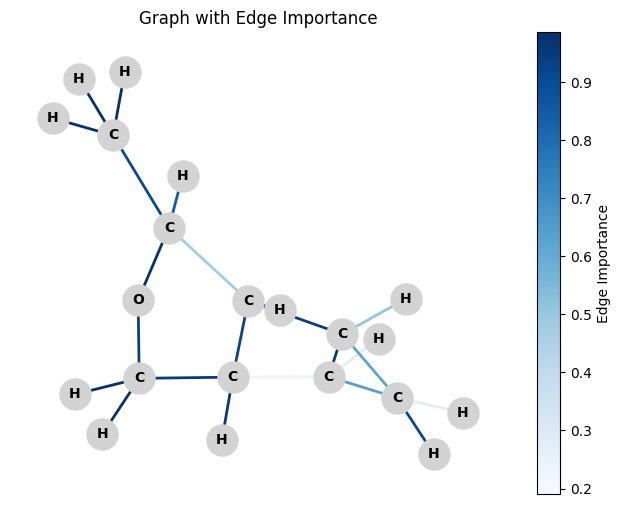

In [40]:
import matplotlib.cm as cm

# Define the model configuration
model_config = ModelConfig(
    mode='binary_classification',          
    task_level='graph',         
    return_type='raw'           
)

# Initialize AttentionExplainer with edge_mask_type specified
explainer = Explainer(
    model=gat_model,               
    algorithm=AttentionExplainer(), 
    explanation_type='model',      
    model_config=model_config,     
    edge_mask_type='object'        
)

# Load the PyTorch Geometric Data object
path = 'ring_example_graph_64.pt' 
example_data = torch.load(path)
example_data = example_data.to(device)

# Get the explanation
explanation = explainer(
    x=example_data.x,                      # Node features
    edge_index=example_data.edge_index,    # Edge connections
    batch=example_data.batch               # Batch information
)

# Extract the edge importance
edge_importance = explanation.edge_mask.cpu().detach().numpy()
edge_index = example_data.edge_index.cpu().numpy()

# Normalize edge importance for visualization
norm_edge = Normalize(vmin=edge_importance.min(), vmax=edge_importance.max())

# Step 2: Convert edge_index to a NetworkX graph
G = nx.Graph()
edge_list = edge_index.T.tolist()  # Convert edge_index to a list of edges
G.add_edges_from(edge_list)

# Map nodes to elements (C, O, N, H)
node_to_element = {}
for node in range(21):  # Assuming there are 21 nodes
    if node in [0, 1, 3, 4, 5, 6, 7, 8]:
        node_to_element[node] = 'C'
    elif node == 2:
        node_to_element[node] = 'O'
    else:
        node_to_element[node] = 'H'

# Step 3: Visualize the graph with edge importance only
cmap_edge = plt.cm.Blues

fig, ax = plt.subplots(figsize=(8, 6))

# Set edge colors based on importance
edge_colors = [cmap_edge(norm_edge(edge_importance[i])) for i in range(len(edge_importance))]

# Replace numeric node labels with 'element' attributes
node_labels = {i: node_to_element[i] for i in G.nodes}

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Positioning nodes using spring layout
nx.draw(
    G, pos,
    with_labels=True,
    labels=node_labels,  # Use 'element' as node labels
    node_color='lightgray',  # Nodes are in a neutral color
    node_size=500,  # Fixed size for nodes
    edge_color=edge_colors,
    width=2,
    font_size=10,
    font_weight='bold',
    ax=ax
)

# Add colorbars for edge importance
sm_edge = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
sm_edge.set_array([])
plt.colorbar(sm_edge, ax=ax, label='Edge Importance')

# Finalize the plot
plt.title('Graph with Edge Importance')
plt.show()


#### Figure 16: Graph with Edge Importance by Attention Explainer
The explainer focuses on the heterocyclic ring containing the oxygen atom, ignoring the other ring, highlighting the model's attention to key structural features.

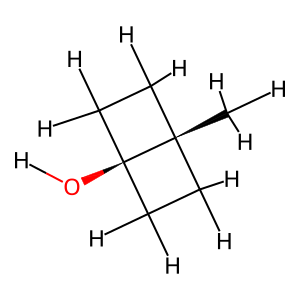

In [41]:
# Load the PyTorch Geometric Data object
path = 'homologous_example_graph_61.pt' 
example_data = torch.load(path)
example_data = example_data.to(device)

smiles=example_data.smiles[0]
# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smiles)

# Add explicit hydrogens to the molecule
mol_with_h = Chem.AddHs(mol)

# Draw the molecule
Draw.MolToImage(mol_with_h, kekulize=True)


#### Figure 17: Smiles Representation of homocyclic ring

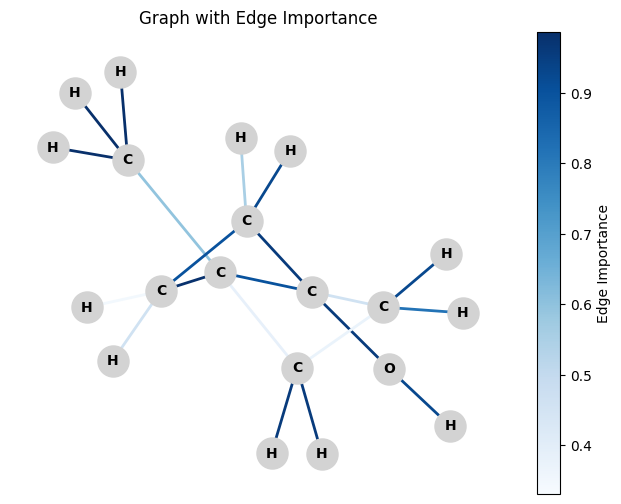

In [42]:
# Define the model configuration
model_config = ModelConfig(
    mode='binary_classification',          
    task_level='graph',         
    return_type='raw'           
)

# Initialize AttentionExplainer with edge_mask_type specified
explainer = Explainer(
    model=gat_model,               
    algorithm=AttentionExplainer(), 
    explanation_type='model',      
    model_config=model_config,     
    edge_mask_type='object'        
)


# Get the explanation
explanation = explainer(
    x=example_data.x,                      # Node features
    edge_index=example_data.edge_index,    # Edge connections
    batch=example_data.batch               # Batch information
)

# Extract the edge importance
edge_importance = explanation.edge_mask.cpu().detach().numpy()
edge_index = example_data.edge_index.cpu().numpy()

# Normalize edge importance for visualization
norm_edge = Normalize(vmin=edge_importance.min(), vmax=edge_importance.max())

# Step 2: Convert edge_index to a NetworkX graph
G = nx.Graph()
edge_list = edge_index.T.tolist()  # Convert edge_index to a list of edges
G.add_edges_from(edge_list)

# Map node indices to elements
node_to_element = {}
for node in range(example_data.num_nodes): 
    if node in [0, 1, 2,3, 4, 6, 7]:
        node_to_element[node] = 'C'
    elif node == 5:
        node_to_element[node] = 'O'
    else:
        node_to_element[node] = 'H'

# Step 3: Visualize the graph with edge importance only
cmap_edge = plt.cm.Blues

fig, ax = plt.subplots(figsize=(8, 6))

# Set edge colors based on importance
edge_colors = [cmap_edge(norm_edge(edge_importance[i])) for i in range(len(edge_importance))]

# Replace numeric node labels with 'element' attributes
node_labels = {i: node_to_element[i] for i in G.nodes}

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Positioning nodes using spring layout
nx.draw(
    G, pos,
    with_labels=True,
    labels=node_labels,  # Use 'element' as node labels
    node_color='lightgray',  # Nodes are in a neutral color
    node_size=500,  # Fixed size for nodes
    edge_color=edge_colors,
    width=2,
    font_size=10,
    font_weight='bold',
    ax=ax
)

# Add colorbars for edge importance
sm_edge = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
sm_edge.set_array([])
plt.colorbar(sm_edge, ax=ax, label='Edge Importance')

# Finalize the plot
plt.title('Graph with Edge Importance')
plt.show()


#### Figure 18: Graph with Edge Importance by Attention Explainer (Homocyclic)
The explainer highlights edges connected to the oxygen atom, emphasizing its significance despite the homocyclic structure.

## Plausibility

- **Definition:**  
  Plausibility measures how well the explanations provided by a method align with human intuition or domain knowledge.
  
- **Purpose:**  
  It evaluates the interpretability of the explanations in terms of human understanding.
  

## Fidelity

- **Definition:**  
  Fidelity assesses how accurately an explanation reflects the actual decision-making process of the model.
  
- **Purpose:**  
  It determines whether the explanation captures the true reasons behind the model's predictions, irrespective of human intuition.
  

## Architecture Impact

- **Definition:**  
  Architecture impact refers to how the choice of Graph Neural Network (GNN) architecture affects the performance, plausibility, and fidelity of explanation methods.

---

### Key Findings 

1. **Varied Explanation Performance Across Architectures:**  
   - The effectiveness of explanation methods (e.g., GNNExplainer, GradCam, SubX) differs significantly based on the underlying GNN architecture.  
   - For instance, methods like GNNExplainer and GradCam show better plausibility and fidelity with certain architectures like GCN or GAT compared to others like GraphSAGE or ChebNet.

2. **Architectural Complexity Matters:**  
   - Complex architectures (e.g., GAT) tend to produce nuanced and less interpretable attention mechanisms, making explanations harder to align with human intuition (plausibility).  
   - Simpler architectures (e.g., GCN) often yield explanations with higher fidelity due to their straightforward aggregation schemes.

---

### Evaluation Metrics

- **Plausibility:**  
  Some architectures inherently align better with human intuition, making their explanations easier to interpret (e.g., attention-based models like GAT).  

- **Fidelity:**  
  Architectures with more expressive mechanisms (e.g., GIN) can pose challenges for explanations to fully capture their internal decision-making processes.





## Explainer Categories 

1. **Gradient-Based Explainers:**
   - Use gradients to identify important features or graph components.
   - **Examples:**  
     - **GradExplNode:** Finds key node features.  
     - **Integrated Gradients:** Smoothly averages gradients for clearer explanations.

2. **Perturbation-Based Explainers:**
   - Test the importance of graph parts (nodes, edges, features) by removing or altering them.
   - **Examples:**  
     - **GNNExplainer:** Identifies key subgraphs and features.  
     - **SubgraphX:** Finds important subgraphs using search methods.

3. **Decomposition-Based Explainers:**
   - Trace model predictions back to input components.
   - **Examples:**  
     - **CAM (Class Activation Maps):** Links class predictions to input features.  
     - **Grad-CAM:** Adds gradient information to CAM for better results.

4. **Surrogate-Based Explainers:**
   - Create simpler models to approximate the GNN’s behavior.
   - **Example:**  
     - **PGMExpl:** Builds a graphical model to explain predictions.

5. **Reinforcement Learning-Based Explainers:**
   - Use iterative learning to generate explanations.
   - **Example:**  
     - **RGExpl:** Learns to pick important subgraphs step by step.



## Task Type Influence

- **Definition:**  
  Task type influence refers to how the type of graph prediction task (e.g., node classification, link prediction, graph classification) impacts the effectiveness and suitability of explanation methods.

---

### Key Insights

1. **Node-Level Tasks:**  
   - Explanation methods focus on identifying important neighboring nodes and features for a specific node.  
   - **Example:**  
     - For **node classification**, methods like **GradExplNode** or **GNNExplainer** highlight node features and edges that contribute to a node's predicted class.

2. **Link-Level Tasks:**  
   - Methods identify edges or pairs of nodes that significantly influence predictions.  
   - **Example:**  
     - In **link prediction**, explainers like **PGMExpl** or **GNNExplainer** focus on the relationship between the two nodes.

3. **Graph-Level Tasks:**  
   - Methods provide explanations for the entire graph by identifying critical subgraphs and features.  
   - **Example:**  
     - For **graph classification**, methods like **SubgraphX** and **Grad-CAM** highlight subgraphs and graph-wide features influencing the prediction.


## Quiz

1. **What is the primary goal of GNNExplainer?**
   - (a) To improve the accuracy of Graph Neural Networks.
   - (b) To provide explanations for predictions made by Graph Neural Networks.
   - (c) To train a Graph Neural Network on large datasets.
   - (d) To generate synthetic graphs for training Graph Neural Networks.

4. **How does GNNExplainer evaluate the quality of its explanations?**
   - (a) By comparing the model’s output before and after perturbations.
   - (b) By calculating the fidelity of the explanations to the original model's predictions.
   - (c) By visualizing the explanation graphs and checking for symmetry.
   - (d) By using manual labels to confirm the correctness of explanations.

5. **What is a key limitation of GNNExplainer?**
   - (a) It requires the graph to be directed.
   - (b) It cannot handle large graphs due to high computational costs.
   - (c) It is only applicable to convolutional neural networks.
   - (d) It works only for node-level explanations and not graph-level ones.
